In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

In [ ]:
path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

In [ ]:
data_bz = data["b2dz5"]
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 40.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 40.0 * 10**-3
pixelsize_y_Mm = 40.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 2000.0 * 10**-3

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [ ]:
Jz = np.gradient(data_by, axis=1) - np.gradient(data_bx, axis=0)

In [ ]:
alpha = np.sum(Jz * np.sign(data_bz)) / np.sum(np.fabs(data_bz))

In [ ]:
alpha

In [ ]:
alpha * 79

In [ ]:
alpha * nresol_x * pixelsize_x_Mm * 2

In [ ]:
print(data_bz.min())
print(data_bz.max())

In [ ]:
alpha = -0.24
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm

length_scale_x_norm = length_scale_x / length_scale 
length_scale_y_norm = length_scale_y / length_scale 

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

print(np.sqrt(k2_arr.min()))
limit = 1 / 2 * (1 - alpha**2 / k2_arr)

print(limit.min())

from scipy.special import jv

# for z in z_arr:
#     print(jv(p, q * np.exp(- z * 0.02 / 2.0)))

# for ix in range(nf_max):
#     for iy in range(nf_max):
#         if jv(p, q)[iy, ix] != 0: print(iy, ix, " : p ", p[iy, ix], " : q ", q[iy, ix])

In [ ]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [ ]:
np.sum(data2d.bz)/np.sum(np.fabs(data2d.bz))

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA/ISSI_original"

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -1100, -700, -300, -100, 0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(
    x_grid,
    y_grid,
    data2d.bz,
    1000,
    cmap=cmap, 
    norm=norm,
)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -1100, -700, -300, -100)),
    colors="white",
    linewidths=0.5,
)
CS2 = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.clabel(CS2, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contourcombi.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
# Erste Version : f berechnet von f_L = 0.5 exp(-0.02 z) s.d. f(0) = f_L(0), f(z0) = f_L(z_0)
from mhsflex.switch import f, f_low

z0 = 2.0
deltaz = 5.0

b = (np.exp(-0.02 * z0) - 1) / (np.exp(-0.02 * z0) * np.tanh(-z0 / deltaz))
a = 0.5 / (1 - b * np.tanh(-z0 / deltaz))

print(a, b)

f_tanh = f(z_arr, z0, deltaz, a, b)

alpha = -0.19

data3d = calculate_magfield(data2d, a, b, alpha, z0, deltaz)

In [ ]:
norm = colors.SymLogNorm(70, vmin=-7.5e2, vmax=7.5e2)

x_arr = np.arange(2*nresol_x) * (xmax_Mm - -xmax_Mm) / (2*nresol_x - 1) - xmax_Mm
y_arr = np.arange(2*nresol_y) * (ymax_Mm - -ymax_Mm) / (2*nresol_y - 1) - ymax_Mm
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contourf(
    x_grid,
    y_grid,
    data3d.field[:, :, 0, 2],
    1000,
    cmap=cmap, 
    norm=norm
)
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contourSee.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
f_exp = f_low(z_arr, 0.5, 0.02)

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    f_exp,
    label=r"$f_L$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
ax1.plot(
    z_arr,
    f_tanh,
    label=r"$f_{N+W}$",
    linewidth=0.5,
    color=c2,
    linestyle="solid",
)


# ax2 = ax1.twinx()

# ax2.plot(
#     z_arr,
#     f_tanh2,
#     label=r"$f_{N+W}$ chose $\alpha$ first",
#     linewidth=0.5,
#     color=c4,
#     linestyle="solid",
# )

# ax2.set_ylim(f_tanh2.min()-0.01, 0.3)

# ax1.plot(
#     z_arr,
#     f_tanh3,
#     label=r"$f_{N+W}$ fit to $f_L$",
#     linewidth=0.5,
#     color=c1,
#     linestyle="solid",
# )

# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# lines = lines1 + lines2
# labels = labels1 + labels2
plt.legend(frameon=False)
# ax1.set_xlabel("z")
ax1.tick_params(direction="in", length=2, width=0.5)
# ax2.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/f.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

# $f(z) = a \cdot [1 - b \cdot \tanh\left(\frac{z - z_0}{\Delta z}\right)]$

In [ ]:
plot(data3d, "side", False, True, path=folder)
plot(data3d, "los", False, True, path=folder)
plot(data3d, "angular", False, True, path=folder)

In [ ]:
show_poles(data3d)

In [ ]:
show_footpoints(data3d)

In [ ]:
path3dref = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
data3dref = readsav(path3dref, python_dict=True, verbose=True)

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

presref = data3dref["p3d"] * 10**-1
denref = data3dref["d3d"] * 10**3


bx_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
by_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bz_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_rec = np.array((by_rec, bx_rec, bz_rec))
B_ref = np.array((issi_by, issi_bx, issi_bz))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    bz_rec[:, :, 0],
    levels=np.array((-1500, -1100, -700, -300, -100, 0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [ ]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy

print(VecCorr(B_ref, B_rec))
print(CauSchw(B_ref, B_rec))
print(NormErr(B_ref, B_rec))
print(MeanErr(B_ref, B_rec))
print(MagEnergy(B_ref, B_rec))

print(VecCorr(B_ref, B_ref))
print(CauSchw(B_ref, B_ref))
print(NormErr(B_ref, B_ref))
print(MeanErr(B_ref, B_ref))
print(MagEnergy(B_ref, B_ref))

In [ ]:
B_ref_See = np.zeros_like(data3d.field)

for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]

In [ ]:
Data3dref = Field3dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    x_arr,
    y_arr,
    z_arr,
    data3d.bz,
    B_ref_See,
    np.zeros_like(B_ref_See),
    data3d.a,
    data3d.b,
    data3d.alpha,
    data3d.z0,
    data3d.deltaz,
    tanh=True,
)

In [ ]:
from mhsflex.metrics import field_div_metric

field_div_metric(Data3dref, data3d)

In [ ]:
temps = np.array([6000.0, 5500.0, 10000.0])
heights = np.array([0.0, z0 / 4, z0])

from mhsflex.field3d import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)

backtemp = btemp_linear(data3d, heights, temps)
backpres = bpressure_linear(data3d, heights, temps)
backden = bdensity_linear(data3d, heights, temps)

In [ ]:
c5 = (1.000, 0.000, 0.773)


c6 = (1.000, 0.780, 0.000)
c7 = (0.443, 1.000, 0.855)
c8 = (0.996, 1.000, 0.000)

c9 = (0.671, 0.714, 1.000)

In [ ]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data2d.bz.max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

In [ ]:
print(BETA0)

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.set_ylabel("Kelvin")
ax2.set_ylabel(r"$kg/(s^2 m)$")
ax3.set_ylabel(r"$kg /(m^3)$")

ax1.set_xlabel("z (Mm)")

ax1.plot(
    data2d.z,
    data3d.btemp,
    linewidth=0.5,
    color=c1,
    label=r"B-Temp",
    linestyle="solid",
)

ax2.plot(
    data2d.z,
    BETA0 / 2.0 * data3d.bpressure * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    color=c2,
    label=r"B-Pres",
    linestyle="solid",
)

ax3.plot(
    data2d.z,
    BETA0
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * data3d.bdensity
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    color=c4,
    label=r"B-Den",
    linestyle="solid",
)

# ax1.plot(
#     data2d.z,
#     backtemp,
#     linewidth=0.5,
#     color=c1,
#     label=r"B-Temp linear",
# )

# ax2.plot(
#     data2d.z,
#     BETA0 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
#     linewidth=0.5,
#     color=c2,
#     label=r"B-Pres linear",
# )

# ax3.plot(
#     data2d.z,
#     BETA0
#     / (2.0 * H)
#     * T0
#     / T_PHOTOSPHERE
#     * backden
#     * (B0 * 10**-4) ** 2.0
#     / (MU0 * G_SOLAR * L),
#     linewidth=0.5,
#     color=c4,
#     label=r"B-Den linear",
# )


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()

lines = lines4 + lines1 + lines3 + lines2
labels = labels4 + labels1 + labels3 + labels2
plt.legend(lines, labels, frameon=False, loc="center", bbox_to_anchor=(1.5, 0.87))

ax3.spines["right"].set_position(("outward", 51))
ax4.get_yaxis().set_visible(False)

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)
ax4.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/batm_tanh.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
maxcoord = np.unravel_index(
    np.argmax(data3d.bz, axis=None),
    data3d.bz.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

In [ ]:
fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

In [ ]:
plt.plot(
    z_arr,
    fpres[0, 0, :],
    linewidth=0.3,
    color=c4,
    label="Recreated pressure",
)
plt.plot(
    z_arr,
    presref[:, 0, 0],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="Reference pressure",
)
for ix in range(1, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fpres[iy, ix, :],
            linewidth=0.3,
            color=c4,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            presref[:, iy, ix],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
plt.plot(
    z_arr,
    fden[0, 0, :],
    linewidth=0.3,
    color=c4,
    label="Recreated density",
)
plt.plot(
    z_arr,
    denref[:, 0, 0],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="Reference density",
)
for ix in range(0, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            fden[iy, ix, :],
            linewidth=0.3,
            color=c4,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            denref[:, iy, ix],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
from mhsflex.metrics import pearson_corr_coeff_issi

pearson_corr_coeff_issi(presref, denref, data3d, heights, temps)

In [17]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA/Low_comp"

z0 = 1.0
deltaz = 0.2

b = 1.0
a = 0.4

# f_tanh = f(z_arr, z0, deltaz, a, b)

alpha = -0.24

data3d = calculate_magfield(data2d, a, b, alpha, z0, deltaz)

# aL = a * (1 - np.tanh(-z0 / deltaz))

# kappa = -np.log(a / aL) / z0

# f_exp = f_low(z_arr, aL, kappa)

# data3dL = calculate_magfield(data2d, a, b, alpha, z0, deltaz, asymptotic=False, tanh=False)

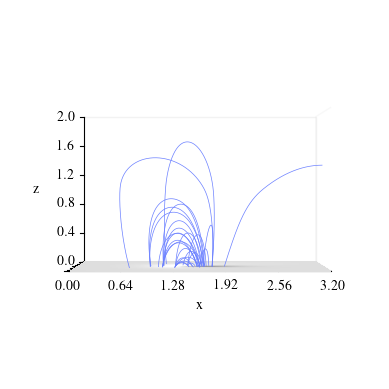

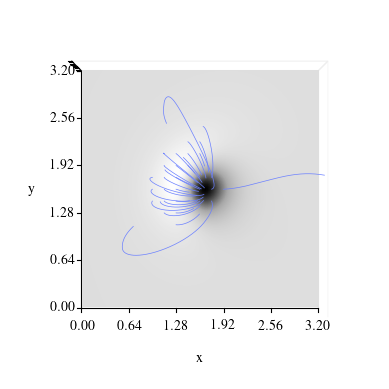

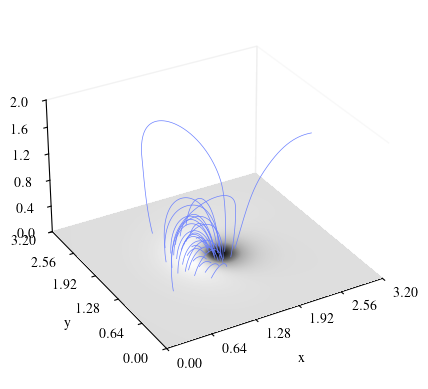

In [18]:
plot(data3d, "side", False)
plot(data3d, "los", False)
plot(data3d, "angular", False)

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    f_exp,
    label=r"$f_L$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
ax1.plot(
    z_arr,
    f_tanh,
    label=r"$f_{N+W}$",
    linewidth=0.5,
    color=c2,
    linestyle="solid",
)
plotname = folder + "/f.png"
ax1.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
plot(data3d, "side", False, True, path=folder)
plot(data3d, "los", False, True, path=folder)
plot(data3d, "angular", False, True, path=folder)

In [ ]:
plot(data3dL, "side", False, True, path=folder+"/Low")
plot(data3dL, "los", False, True, path=folder+"/Low")
plot(data3dL, "angular", False, True, path=folder+"/Low")

In [ ]:
compare_field3d(data3dL, data3d)

In [ ]:
backtemp = btemp_linear(data3d, heights, temps)
backpres = bpressure_linear(data3d, heights, temps)
backden = bdensity_linear(data3d, heights, temps)

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.set_ylabel("Kelvin")
ax2.set_ylabel(r"$kg/(s^2 m)$")
ax3.set_ylabel(r"$kg /(m^3)$")

ax1.set_xlabel("z (Mm)")

ax4.plot(
    data2d.z,
    data3d.btemp,
    linewidth=0.5,
    color=c1,
    label=r"B-Temp alt, $5600-10^6$ K",
    linestyle="dashed",
)

ax2.plot(
    data2d.z,
    BETA0 / 2.0 * data3d.bpressure * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    color=c2,
    label=r"B-Pres alt",
    linestyle="dashed",
)

ax3.plot(
    data2d.z,
    BETA0
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * data3d.bdensity
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    color=c4,
    label=r"B-Den alt",
    linestyle="dashed",
)

ax1.plot(
    data2d.z,
    backtemp,
    linewidth=0.5,
    color=c1,
    label=r"B-Temp linear",
)

ax2.plot(
    data2d.z,
    BETA0 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    color=c2,
    label=r"B-Pres linear",
)

ax3.plot(
    data2d.z,
    BETA0
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * backden
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    color=c4,
    label=r"B-Den linear",
)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()

lines = lines4 + lines1 + lines3 + lines2
labels = labels4 + labels1 + labels3 + labels2
plt.legend(lines, labels, frameon=False, loc="center", bbox_to_anchor=(1.5, 0.87))

ax3.spines["right"].set_position(("outward", 51))
ax4.get_yaxis().set_visible(False)

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)
ax4.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/batm.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

fpresL = fpressure_linear(data3dL, heights, temps)
fdenL = fdensity_linear(data3dL, heights, temps)

In [ ]:
plt.plot(
    z_arr,
    fpres[0, 0, :],
    linewidth=0.3,
    color=c4,
    label="Recreated pressure",
)
plt.plot(
    z_arr,
    fpresL[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="Reference pressure",
)
for ix in range(1, nresol_x, 3):
    for iy in range(1, nresol_y, 3):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fpres[iy, ix, :],
            linewidth=0.3,
            color=c4,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            fpresL[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
plt.plot(
    z_arr,
    fden[0, 0, :],
    linewidth=0.3,
    color=c4,
    label="Recreated density",
)
plt.plot(
    z_arr,
    fdenL[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="Reference density",
)
for ix in range(1, nresol_x, 3):
    for iy in range(1, nresol_y, 3):
        plt.plot(
            z_arr,
            fden[iy, ix, :],
            linewidth=0.3,
            color=c4,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            fdenL[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

### POTENTIAL, LFF, MHS COMPARISON

In [ ]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"
from mhsflex.switch import f, f_low

z0 = 1.4
deltaz = 0.2

f1 = np.zeros(nresol_z)
f2 = np.zeros(nresol_z)
f3 = np.zeros(nresol_z)

alpha = 0.2
a = 0.0
b = 1.0

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f1[iz] = f(z, z0, deltaz, 0, b)
    f2[iz] = f(z, z0, deltaz, 0.2, b)
    f3[iz] = f(z, z0, deltaz, 0.4, b)

plt.plot(
    z_arr,
    f1,
    label=r"$a = 0$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.plot(
    z_arr,
    f2,
    label=r"$a =0.2$",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    f3,
    label=r"$a =0.4$",
    linewidth=0.5,
    color="black",
    linestyle="dotted",
)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/f.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
data3dp = calculate_magfield(data2d, 0.0, b, 0.0, z0, deltaz)
data3dlff = calculate_magfield(data2d, 0.0, b, 0.2, z0, deltaz)
data3dm1 = calculate_magfield(data2d, 0.2, b, 0.2, z0, deltaz)
data3dm2 = calculate_magfield(data2d, 0.4, b, 0.2, z0, deltaz)

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA/MHS2"

plot(data3dm2, "los", False, True, path=folder)
plot(data3dm2, "side", False, True, path=folder)
plot(data3dm2, "angular", False, True, path=folder)

In [ ]:
compare_field3d(data3dlff, data3dm1)

In [ ]:
compare_field3d(data3dm1, data3dm2)

In [ ]:
compare_field3d(data3dlff, data3dm2)

In [ ]:
from mhsflex.field3d import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)

temps = np.array([6000.0, 5500.0, 10000.0])
heights = np.array([0.0, z0 / 4, z0])

fpreslff = fpressure_linear(data3dlff, heights, temps)
fdenlff = fdensity_linear(data3dlff, heights, temps)

fpresm1 = fpressure_linear(data3dm1, heights, temps)
fdenm1 = fdensity_linear(data3dm1, heights, temps)

fpresm2 = fpressure_linear(data3dm2, heights, temps)
fdenm2 = fdensity_linear(data3dm2, heights, temps)

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"
plt.plot(
    z_arr,
    fpresm1[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="MHS low-a",
)
plt.plot(
    z_arr,
    fpresm2[0, 0, :],
    linewidth=0.3,
    color=c4,
    # linestyle="dashed",
    label="MHS high-a",
)
for ix in range(1, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fpresm1[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
        plt.plot(
            z_arr,
            fpresm2[iy, ix, :],
            linewidth=0.3,
            color=c4,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.plot(
    z_arr,
    fpreslff[0, 0, :],
    linewidth=0.3,
    color="black",
    label="LFF",
)
plt.ylabel("$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
plt.plot(
    z_arr,
    fdenm1[0, 0, :],
    linewidth=0.3,
    color=c2,
    label="MHS low-a",
)
plt.plot(
    z_arr,
    fdenm2[0, 0, :],
    linewidth=0.3,
    color=c4,
    # linestyle="dashed",
    label="MHS high-a",
)
for ix in range(0, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            fdenm1[iy, ix, :],
            linewidth=0.3,
            color=c2,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            fdenm2[iy, ix, :],
            linewidth=0.3,
            color=c4,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.plot(
    z_arr,
    fdenlff[0, 0, :],
    linewidth=0.3,
    color="black",
    label="LFF",
)
plt.ylabel(r"$\rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
np.unravel_index(
    np.argmin(data3dm2.ddensity, axis=None),
    data3dm2.ddensity.shape,
)

In [ ]:
np.unravel_index(
    np.argmin(data3dm1.dpressure, axis=None),
    data3dm2.dpressure.shape,
)

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"
plt.plot(
    z_arr,
    data3dm1.dpressure[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="MHS low-a",
)
plt.plot(
    z_arr,
    data3dm2.dpressure[0, 0, :],
    linewidth=0.3,
    color=c4,
    # linestyle="dashed",
    label="MHS high-a",
)
# for ix in range(40, 50, 3):
#     for iy in range(40, 50, 3):
for ix in range(1, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            data3dm1.dpressure[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
        plt.plot(
            z_arr,
            data3dm2.dpressure[iy, ix, :],
            linewidth=0.3,
            color=c4,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.plot(
    z_arr,
    data3dlff.dpressure[0, 0, :],
    linewidth=0.3,
    color="black",
    label="LFF",
)
plt.ylabel("$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"
plt.plot(
    z_arr,
    data3dm1.ddensity[0, 0, :],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="MHS low-a",
)
plt.plot(
    z_arr,
    data3dm2.ddensity[0, 0, :],
    linewidth=0.3,
    color=c4,
    # linestyle="dashed",
    label="MHS high-a",
)
# for ix in range(40, 50, 3):
#     for iy in range(40, 50, 3):
for ix in range(0, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            data3dm1.ddensity[iy, ix, :],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
        plt.plot(
            z_arr,
            data3dm2.ddensity[iy, ix, :],
            linewidth=0.3,
            color=c4,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.plot(
    z_arr,
    data3dlff.ddensity[0, 0, :],
    linewidth=0.3,
    color="black",
    label="LFF",
)
plt.ylabel("$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()